<p align="center">
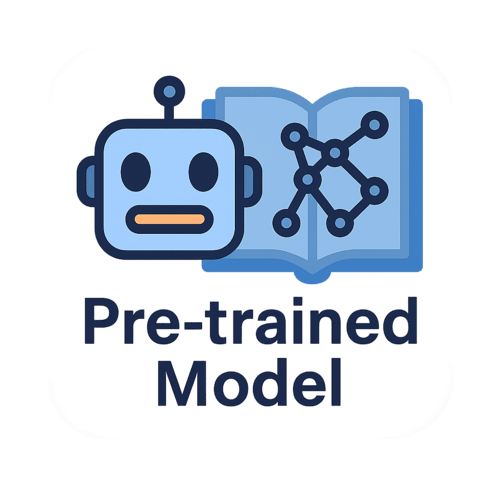
</p>

<font color='Green' size='5'><b> **Pre-trained model** </b></font>

A pre-trained model is a machine learning (ML) model that has been trained on a large dataset and can be fine-tuned for a specific task. Pre-trained models are often used as a starting point for developing ML models, as they provide a set of initial weights and biases that can be fine-tuned for a specific task.

<font color='brown' size='5'><b> **Inception v3** </b></font>

InceptionV3 is a convolutional neural network (CNN) architecture developed by Google, introduced in 2015 as an improved version of InceptionV1 (GoogLeNet). It is widely used for image classification tasks due to its balance between accuracy and computational efficiency. used for object recognition tasks.

Trained on ImageNet: Can recognize 1,000 categories of objects.



<font color='brown' size='5'><b> **Architecture InceptionV3** </b></font>



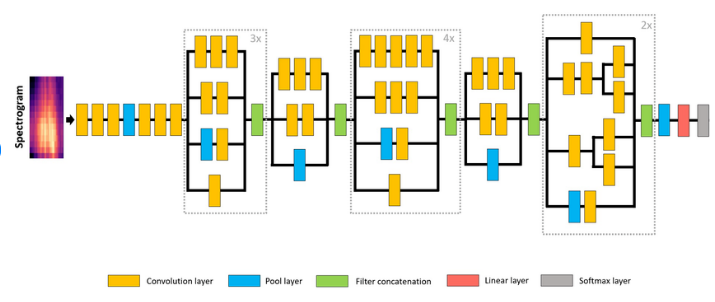

This  diagram shows a simplified architecture with:

Convolution layer → Local feature extraction.

Pool layer → Dimensionality reduction (e.g., max-pooling).

Filter concatenation → Feature fusion (similar to Inception modules).

Linear + Softmax → Classification.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from PIL import UnidentifiedImageError

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

# Vérifiez si le dossier existe
directory = '/content/drive/MyDrive/PlantVillage'
if os.path.isdir(directory):
    print("Le dossier existe !")
else:
    print("Le dossier n'existe pas.")

Le dossier existe !


In [6]:
# Chemin du dataset
data_dir = '/content/drive/MyDrive/PlantVillage'

# Détection du vrai dossier si sous-dossier unique
subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
if len(subdirs) == 1 and subdirs[0] == "PlantVillage":
    data_dir = os.path.join(data_dir, "PlantVillage")

# Paramètres
img_size = (128, 128)
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(classes)
label_mapping = dict(zip(classes, encoded_labels))

def load_data(directory, target_size, label_mapping):
    images, labels = [], []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            try:
                img = load_img(os.path.join(class_path, img_name), target_size=target_size)
                images.append(img_to_array(img) / 255.0)
                labels.append(label_mapping[class_name])
            except UnidentifiedImageError:
                print(f"Image non valide : {img_name}")
    return np.array(images), np.array(labels)

x_data, y_data = load_data(data_dir, img_size, label_mapping)
print(f"Images: {x_data.shape}, Labels: {y_data.shape}")

Images: (20638, 128, 128, 3), Labels: (20638,)


In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_aug = ImageDataGenerator()

In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 61, 61,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 30,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 22,331,440 (85.19 MB)

 Trainable params: 528,656 (2.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [9]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    train_aug.flow(x_train, y_train_cat, batch_size=32),
    epochs=20,
    validation_data=val_aug.flow(x_val, y_val_cat),
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2421 - loss: 2.7888

516/516 ━━━━━━━━━━━━━━━━━━━━ 789s 2s/step - accuracy: 0.2423 - loss: 2.7877 - val_accuracy: 0.5816 - val_loss: 1.3615
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4963 - loss: 1.6013

516/516 ━━━━━━━━━━━━━━━━━━━━ 765s 1s/step - accuracy: 0.4963 - loss: 1.6012 - val_accuracy: 0.6468 - val_loss: 1.1067
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5619 - loss: 1.3818

516/516 ━━━━━━━━━━━━━━━━━━━━ 761s 1s/step - accuracy: 0.5620 - loss: 1.3817 - val_accuracy: 0.6768 - val_loss: 1.0312
Epoch 4/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6016 - loss: 1.2388

516/516 ━━━━━━━━━━━━━━━━━━━━ 760s 1s/step - accuracy: 0.6016 - loss: 1.2388 - val_accuracy: 0.6989 - val_loss: 0.9383
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6211 - loss: 1.1817

516/516 ━━━━━━━━━━━━━━━━━━━━ 764s 1s/step - accuracy: 0.6211 - loss: 1.1816 - val_accuracy: 0.7120 - val_loss: 0.8874
Epoch 6/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6364 - loss: 1.1237

516/516 ━━━━━━━━━━━━━━━━━━━━ 761s 1s/step - accuracy: 0.6364 - loss: 1.1237 - val_accuracy: 0.7292 - val_loss: 0.8476
Epoch 7/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6460 - loss: 1.0791

516/516 ━━━━━━━━━━━━━━━━━━━━ 759s 1s/step - accuracy: 0.6460 - loss: 1.0791 - val_accuracy: 0.7243 - val_loss: 0.8372
Epoch 8/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6635 - loss: 1.0269

516/516 ━━━━━━━━━━━━━━━━━━━━ 774s 2s/step - accuracy: 0.6635 - loss: 1.0268 - val_accuracy: 0.7374 - val_loss: 0.8058
Epoch 9/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6717 - loss: 0.9880

516/516 ━━━━━━━━━━━━━━━━━━━━ 797s 1s/step - accuracy: 0.6717 - loss: 0.9880 - val_accuracy: 0.7401 - val_loss: 0.8038
Epoch 10/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6807 - loss: 0.9795

516/516 ━━━━━━━━━━━━━━━━━━━━ 762s 1s/step - accuracy: 0.6807 - loss: 0.9795 - val_accuracy: 0.7459 - val_loss: 0.7628
Epoch 11/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6864 - loss: 0.9679

516/516 ━━━━━━━━━━━━━━━━━━━━ 799s 1s/step - accuracy: 0.6864 - loss: 0.9679 - val_accuracy: 0.7531 - val_loss: 0.7560
Epoch 12/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 801s 1s/step - accuracy: 0.7029 - loss: 0.9230 - val_accuracy: 0.7551 - val_loss: 0.7578
Epoch 13/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6972 - loss: 0.9278

516/516 ━━━━━━━━━━━━━━━━━━━━ 765s 1s/step - accuracy: 0.6972 - loss: 0.9278 - val_accuracy: 0.7594 - val_loss: 0.7224
Epoch 14/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 767s 1s/step - accuracy: 0.7049 - loss: 0.9107 - val_accuracy: 0.7616 - val_loss: 0.7225
Epoch 15/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7045 - loss: 0.9107

516/516 ━━━━━━━━━━━━━━━━━━━━ 796s 1s/step - accuracy: 0.7045 - loss: 0.9107 - val_accuracy: 0.7636 - val_loss: 0.7192
Epoch 16/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7025 - loss: 0.8906

516/516 ━━━━━━━━━━━━━━━━━━━━ 755s 1s/step - accuracy: 0.7025 - loss: 0.8906 - val_accuracy: 0.7657 - val_loss: 0.7032
Epoch 17/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7065 - loss: 0.8810

516/516 ━━━━━━━━━━━━━━━━━━━━ 823s 2s/step - accuracy: 0.7065 - loss: 0.8810 - val_accuracy: 0.7750 - val_loss: 0.6880
Epoch 18/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7111 - loss: 0.8615

516/516 ━━━━━━━━━━━━━━━━━━━━ 765s 1s/step - accuracy: 0.7111 - loss: 0.8615 - val_accuracy: 0.7711 - val_loss: 0.6869
Epoch 19/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7209 - loss: 0.8534

516/516 ━━━━━━━━━━━━━━━━━━━━ 757s 1s/step - accuracy: 0.7209 - loss: 0.8534 - val_accuracy: 0.7762 - val_loss: 0.6735
Epoch 20/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 759s 1s/step - accuracy: 0.7152 - loss: 0.8550 - val_accuracy: 0.7737 - val_loss: 0.6874


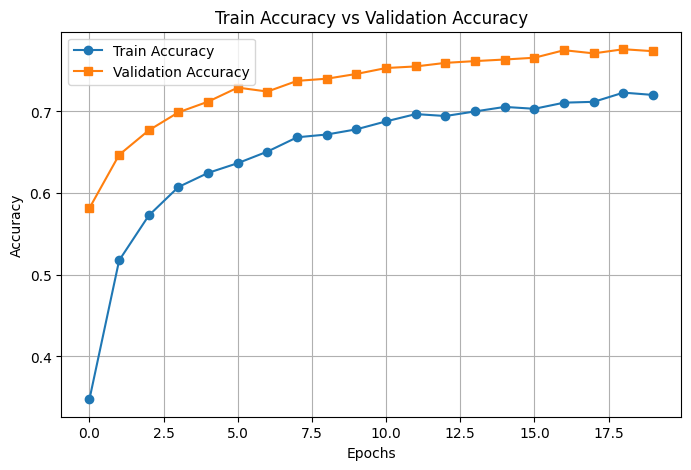

In [10]:
import matplotlib.pyplot as plt

# Plot training vs validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')

# Formatting the graph
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


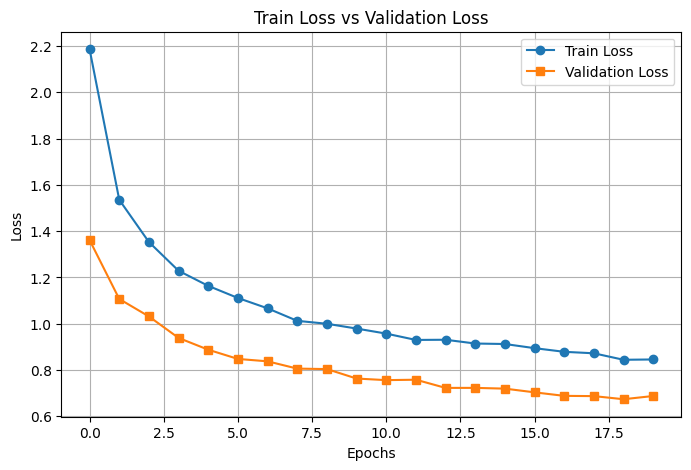

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
